# Lender Segmentations of Kiva.org


## Outline of this notebook

**1. Data loading and processing**  

    1.1 loadind  
    1.2 labeling outliers  
    1.3 interactions among outliers
    
**2. Feature engineering & Dimensionality reduction**  
    
**3. KMeans++ Clustering**  

**4. Interpretations**  

    4.1 "centroid person"
    4.2 3D visulization
    4.3 radar charts

**5. Segments**

    5.1 Account age and last login month
## 1. Data 

### 1.1 loading scripts and libraries

In [6]:
from main import *

In [7]:
from full_data_pipeline import *

In [47]:
from ploting import *

In [9]:
from model import *

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

%load_ext autoreload
%autoreload 2

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [12]:
df = read_full_data()

In [13]:
df.shape

(2945384, 105)

### 1.2 Labeling outliers

In [14]:
df = create_lenders_labels(df)

In [15]:
df.shape

(2945384, 109)

In [16]:
normal = df[~df['dollar_outliers?']][~df['team_outliers?']][~df['comments_outliers?']][~df['dollar_zeros?']]

In [17]:
normal.shape

(1017355, 109)

In [18]:
normal.shape[0]/df.shape[0]

0.34540657516982504

In [19]:
df['dollar_outliers?'].sum()/df.shape[0]

0.27243171009280964

In [20]:
df['team_outliers?'].sum()/df.shape[0]

0.02695030597029114

In [21]:
df['comments_outliers?'].sum()/df.shape[0]

0.010218362020028628

### 1.3 lot interactions among super users

In [22]:
a = df['dollar_outliers?'].sum()
a

802416

In [23]:
b = df['team_outliers?'].sum()
b

79379

In [24]:
c = df['comments_outliers?'].sum()
c

30097

In [25]:
a_and_c = df[df['dollar_outliers?']]['comments_outliers?'].sum()
a_and_c

18081

In [26]:
a_and_b = df[df['dollar_outliers?']]['team_outliers?'].sum()
a_and_b

63129

In [27]:
b_and_c = df[df['comments_outliers?']]['team_outliers?'].sum()
b_and_c

6853

In [42]:
a_and_b_and_c = df[df['dollar_outliers?'] == True][df['comments_outliers?'] == True][df['team_outliers?'] == True].shape[0]
a_and_b_and_c

6211

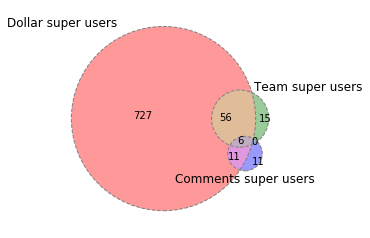

In [75]:
plot_venn_3(a,b,c,a_and_b,a_and_c,b_and_c,a_and_b_and_c,a_label="Dollar super users",b_label="Team super users",c_label="Comments super users")

In [14]:
df['dollar_zeros?'].sum()/df.shape[0]

0.37610817468961605

In [22]:
df[df['dollar_outliers?']]["LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL"].sum()/df['LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL'].sum()

0.9424237652661854

In [23]:
df[df['dollar_outliers?']]["FIRST_YEAR_LOAN_PURCHASE_TOTAL"].sum()/df['FIRST_YEAR_LOAN_PURCHASE_TOTAL'].sum()

0.8554114362949918

In [24]:
df[df['dollar_outliers?']]["FIRST_DAY_LOAN_PURCHASE_TOTAL"].sum()/df['FIRST_DAY_LOAN_PURCHASE_TOTAL'].sum()

0.726582289324033

## 2. Feature Engineering and Dimensionality Reduction

In [22]:
ndf_ww, X_ww = feature_engineer(normal,drop_loan_preference=True,drop_first_loan_region=True,drop_loan_regions=True)

In [23]:
ndf_ww.shape

(1017355, 59)

In [29]:
important_features = []
pcd = PCA(10).fit(X_ww)
pca_matrix = pcd.components_
for i in range(10):
    print('#{} Principle Component top 5 contributors are:'.format(i), np.argsort(np.abs(pca_matrix[i,:]))[-5:])
    important_features.append(np.argsort(np.abs(pca_matrix[i,:]))[-5:])
re_X_ww = np.dot(X_ww,pcd.components_.T)
print('Reduced X shape:', re_X_ww.shape)

imp_f_ww = np.array(important_features)
print('Explained variance:', pcd.explained_variance_)
print('Explained variance ratio:', pcd.explained_variance_ratio_)
print('Explained variance ratio accumulated:', pcd.explained_variance_ratio_.cumsum())

#0 Principle Component top 5 contributors are: [11 14  9 17 38]
#1 Principle Component top 5 contributors are: [33 23 35 10 18]
#2 Principle Component top 5 contributors are: [13 21 47 54 39]
#3 Principle Component top 5 contributors are: [20 40 13 21  2]
#4 Principle Component top 5 contributors are: [16 50 49 15 37]
#5 Principle Component top 5 contributors are: [ 8 36  2 33  0]
#6 Principle Component top 5 contributors are: [40 34  1 36 51]
#7 Principle Component top 5 contributors are: [ 2 33  3 51 47]
#8 Principle Component top 5 contributors are: [51 53 52 49 34]
#9 Principle Component top 5 contributors are: [52 20 12 40 41]
Reduced X shape: (1017355, 10)
Explained variance: [8.43050318 4.76182215 3.71015778 2.91601232 2.4442974  2.14436561
 1.88815633 1.60317477 1.16944778 1.13093649]
Explained variance ratio: [0.17205092 0.09717995 0.07571743 0.0595104  0.04988357 0.04376252
 0.03853376 0.03271782 0.02386626 0.02308031]
Explained variance ratio accumulated: [0.17205092 0.26923

Text(0,0.5,'Accumulated Explained Variance')

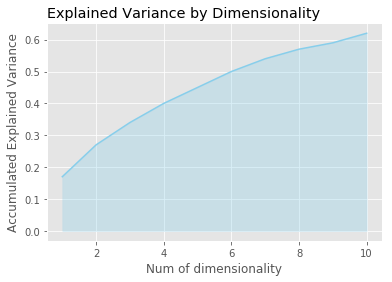

In [34]:
# Plot explained variance by dimensionality
x = range(1,11)
y = np.round(pcd.explained_variance_ratio_.cumsum(),2)
plt.fill_between( x, y, color="skyblue", alpha=0.3)
plt.plot(x, y, color="skyblue")
 
# Add titles and labels
plt.title("Explained Variance by Dimensionality", loc="left")
plt.xlabel("Num of dimensionality")
plt.ylabel("Accumulated Explained Variance")

**Based on PCA result, I choose to keep 6 dimensionalities while still retaining ~50% of the signals. Since we will use a distance-based clustering algorithm later, lower dimensionality will be preferred.**

In [57]:
pcd = PCA(6).fit(X_ww) #re-assign PCA class to reduce to 6 dimensionality

In [39]:
re_X_ww = re_X_ww[:,:6] #cut dimensiontly from 10 to 6

In [43]:
# print out top 5 contributers for each principle component to understand what features are providing signals
counter = print_imp_features(ndf_ww,imp_f_ww[:6,:])

#1 PC:
FIRST_YEAR_DONATION_TOTAL
FIRST_DAY_DEPOSIT_TOTAL
FIRST_YEAR_DEPOSIT_TOTAL
FIRST_YEAR_DEPOSIT_OCCASION_NUM
FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY_none
#2 PC:
last_login_today_months
NUM_TEAM_LOANS
ave_loan_purchase_per_month
FIRST_YEAR_LOAN_PURCHASE_TOTAL
FIRST_YEAR_LOAN_PURCHASE_OCCASION_NUM
#3 PC:
FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_TOTAL
FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_OCCASION_NUM
FIRST_TRANSACTION_REFERRAL_unknown
FIRST_BASKET_CATEGORY_Kiva Card Redeemer
FIRST_TRANSACTION_REFERRAL_giftcard
#4 PC:
FIRST_YEAR_EMAIL_REFERRAL_DONATION_OCCASION_NUM
FIRST_TRANSACTION_REFERRAL_invited
FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_TOTAL
FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_OCCASION_NUM
IS_FREE_TRIAL_USER
#5 PC:
FIRST_DAY_DONATION_TOTAL
FIRST_BASKET_CATEGORY_Depositor - Lender Donor
FIRST_BASKET_CATEGORY_Depositor - Kiva Card NonDonor
FIRST_DAY_LOAN_PURCHASE_TOTAL
FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY_kiva
#6 PC:
LIFETIME_LENDER_WEIGHTED_AVERAGE_LOAN_TERM
FIRST_TIME_DEPO

**We will use 3 dimensionality here for visualization purpose.**

In [36]:
re_X_3 = re_X_ww[:,:3]

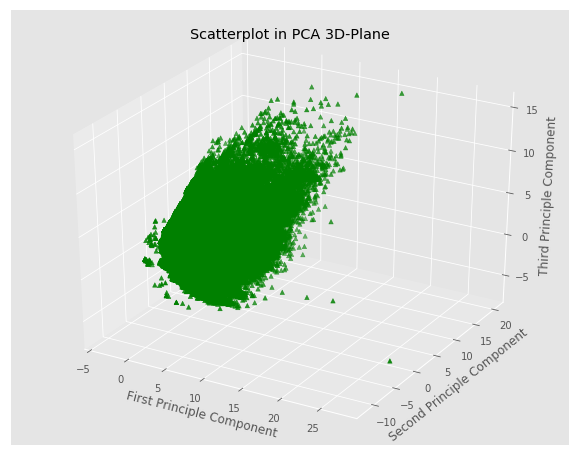

In [37]:
matplotlib_3D_X_reduced(re_X_3)

In [ ]:
plotly_3D_reduced_X(re_X_3)

## 3. Kmeans++ Clustering 

In [44]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=10,tol=0.0001,verbose=0)
y = kmeans.fit_predict(re_X_ww)
centers = kmeans.cluster_centers_

In [80]:
y

array([3, 2, 2, ..., 0, 2, 2], dtype=int32)

In [45]:
ndf_ww['clustering_6d'] = y

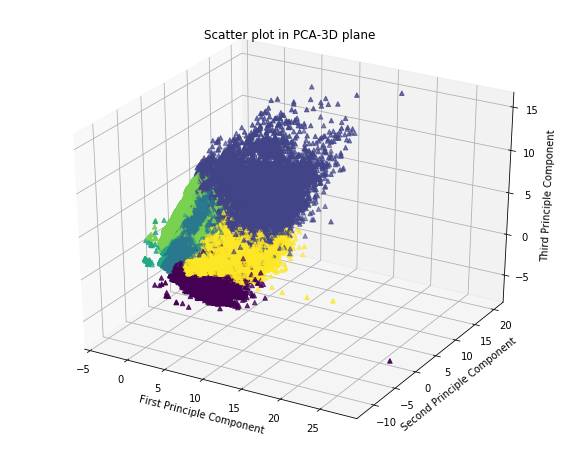

In [52]:
plot_3D_kmeans(re_X_3,y,"First Principle Component","Second Principle Component","Third Principle Component",'Scatter plot in PCA-3D plane')

In [49]:
ndf_ww.head()

,ACCOUNT_AGE_MONTHS,IS_CORPORATE_CAMPAIGN_USER,IS_FREE_TRIAL_USER,IS_INACTIVE_CREDIT_DONOR,LIFETIME_DONATION_TOTAL,LIFETIME_DEPOSIT_TOTAL,LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL,LIFETIME_PROXY_LOAN_PURCHASE_TOTAL,LIFETIME_LENDER_WEIGHTED_AVERAGE_LOAN_TERM,FIRST_YEAR_DEPOSIT_TOTAL,...,FIRST_BASKET_CATEGORY_Depositor - Lender Donor,FIRST_BASKET_CATEGORY_Depositor - Lender NonDonor,FIRST_BASKET_CATEGORY_Depositor - Other,FIRST_BASKET_CATEGORY_Donor,FIRST_BASKET_CATEGORY_Kiva Card Redeemer,FIRST_BASKET_CATEGORY_Promo Lender,FIRST_BASKET_CATEGORY_Zombie,FIRST_BASKET_CATEGORY_Other,FIRST_BASKET_CATEGORY_Kiva Card Partial Promo Redeemer,clustering_6d
1,101,0,0,False,0.00,68.010002,125,0,17.600,0.0,...,0,1,0,0,0,0,0,0,0,5
2,100,0,0,False,7.50,57.500000,50,0,24.000,0.0,...,1,0,0,0,0,0,0,0,0,2
3,119,0,0,False,11.25,55.310001,100,0,21.500,0.0,...,1,0,0,0,0,0,0,0,0,2
4,81,0,0,False,3.75,28.750000,50,0,15.500,0.0,...,1,0,0,0,0,0,0,0,0,4
5,133,0,0,False,30.00,135.179993,200,0,19.875,0.0,...,1,0,0,0,0,0,0,0,0,2


**population of each group / total population of normal users**

In [82]:
ndf_ww.groupby('clustering_6d')['ACCOUNT_AGE_MONTHS'].count()/ndf_ww.shape[0]

clustering_6d
0    0.300638
1    0.198503
2    0.258323
3    0.071718
4    0.146167
5    0.024650
Name: ACCOUNT_AGE_MONTHS, dtype: float64

## 4. Interpretations

### 4.1 "Centroid Person"

**Use Inverse transform to transform cluster centers to meaningful data**

In [58]:
scaled_centers = pcd.inverse_transform(centers)

In [59]:
scaler = StandardScaler().fit(ndf_ww.iloc[:,:-1])

In [60]:
engineered_centers = scaler.inverse_transform(scaled_centers)

In [61]:
center_person = pd.DataFrame(engineered_centers,columns=ndf_ww.columns[:-1])

In [62]:
center_person

,ACCOUNT_AGE_MONTHS,IS_CORPORATE_CAMPAIGN_USER,IS_FREE_TRIAL_USER,IS_INACTIVE_CREDIT_DONOR,LIFETIME_DONATION_TOTAL,LIFETIME_DEPOSIT_TOTAL,LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL,LIFETIME_PROXY_LOAN_PURCHASE_TOTAL,LIFETIME_LENDER_WEIGHTED_AVERAGE_LOAN_TERM,FIRST_YEAR_DEPOSIT_TOTAL,FIRST_YEAR_LOAN_PURCHASE_TOTAL,FIRST_YEAR_DONATION_TOTAL,FIRST_YEAR_EMAIL_REFERRAL_DONATION_TOTAL,FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_TOTAL,FIRST_DAY_DEPOSIT_TOTAL,FIRST_DAY_LOAN_PURCHASE_TOTAL,FIRST_DAY_DONATION_TOTAL,FIRST_YEAR_DEPOSIT_OCCASION_NUM,FIRST_YEAR_LOAN_PURCHASE_OCCASION_NUM,FIRST_YEAR_DONATION_OCCASION_NUM,FIRST_YEAR_EMAIL_REFERRAL_DONATION_OCCASION_NUM,FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_OCCASION_NUM,NUM_TEAM_MEMBERSHIPS,NUM_TEAM_LOANS,NUM_TEAM_MESSAGES,NUM_LOAN_COMMENTS,NUM_JOURNAL_COMMENTS,NUM_STATEMENT_COMMENTS,NUM_EXPIRING_SOON_LOANS,dollar_outliers?,team_outliers?,comments_outliers?,dollar_zeros?,last_login_today_months,lifetime_ave_donation_rate,ave_loan_purchase_per_month,FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY_direct,FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY_kiva,FIRST_TIME_DEPOSITOR_REPORTING_CATEGORY_none,FIRST_TRANSACTION_REFERRAL_giftcard,FIRST_TRANSACTION_REFERRAL_invited,FIRST_TRANSACTION_REFERRAL_invited_team,FIRST_TRANSACTION_REFERRAL_marketing,FIRST_TRANSACTION_REFERRAL_online_ad,FIRST_TRANSACTION_REFERRAL_search,FIRST_TRANSACTION_REFERRAL_social,FIRST_TRANSACTION_REFERRAL_system_email,FIRST_TRANSACTION_REFERRAL_unknown,FIRST_TRANSACTION_REFERRAL_video_site,FIRST_BASKET_CATEGORY_Depositor - Kiva Card NonDonor,FIRST_BASKET_CATEGORY_Depositor - Lender Donor,FIRST_BASKET_CATEGORY_Depositor - Lender NonDonor,FIRST_BASKET_CATEGORY_Depositor - Other,FIRST_BASKET_CATEGORY_Donor,FIRST_BASKET_CATEGORY_Kiva Card Redeemer,FIRST_BASKET_CATEGORY_Promo Lender,FIRST_BASKET_CATEGORY_Zombie,FIRST_BASKET_CATEGORY_Other,FIRST_BASKET_CATEGORY_Kiva Card Partial Promo Redeemer
0,65.640076,0.089287,-0.011921,0.177347,11.335986,35.755139,75.957597,-1.391559e-17,19.267008,28.551506,31.308539,3.088131,-0.021022,0.000842,24.584836,22.849312,2.497822,1.114965,1.252797,0.950558,0.021084,-0.000723,0.251271,0.673928,0.0,0.0,0.0,0.0,0.285625,0.0,0.0,0.0,0.0,34.714988,0.393608,1.597792,0.187722,0.072751,0.073035,0.037449,0.077631,0.008267,0.025706,0.008547,0.072105,0.040283,-0.002299,0.587092,0.000645,0.009290,0.669321,0.146968,0.002255,-0.000288,0.037354,0.071399,0.0,0.000037,0.004879
1,69.219135,0.284092,0.710370,0.106380,1.125209,-1.539756,8.574456,-2.496392e-17,10.878554,0.682316,25.242016,0.177602,-0.038502,-0.200166,0.631592,24.774187,0.127310,0.018158,1.010254,0.059593,0.038285,0.198333,0.498700,0.253787,0.0,0.0,0.0,0.0,-0.085850,0.0,0.0,0.0,0.0,68.397710,0.097821,-0.172361,-0.074161,0.014201,0.992211,-0.016490,0.568819,0.105962,0.020045,-0.002578,-0.012833,-0.011783,0.005886,0.206495,0.000453,0.007786,0.034288,-0.037671,-0.003186,-0.000221,-0.016432,0.995764,0.0,0.000927,0.004077
2,36.312306,0.799192,0.132082,-0.055993,-1.456057,1.402994,64.914986,8.823550e-18,20.711373,0.510363,36.206544,-0.262116,0.024324,-0.024173,0.796615,25.047283,-0.142540,0.013522,1.449490,-0.076138,-0.024169,0.024166,0.989588,2.249642,0.0,0.0,0.0,0.0,0.281480,0.0,0.0,0.0,0.0,23.173839,-0.178795,1.958427,0.051495,-0.005173,0.949357,0.015282,0.075313,0.027552,0.012828,0.001817,0.011491,0.012274,0.002987,0.502476,0.000261,-0.000283,-0.002146,0.073295,0.001602,0.000159,0.015226,0.929039,0.0,0.000294,0.000587
3,79.945264,0.034690,-0.012695,0.361974,13.398488,5.630869,77.836300,3.701562e-20,17.038901,0.255132,29.794854,0.375768,-0.007068,-0.096100,-0.017345,21.933490,0.204030,0.097563,1.163067,0.108007,0.006998,0.095050,0.044763,0.147629,0.0,0.0,0.0,0.0,0.322974,0.0,0.0,0.0,0.0,44.467730,0.527981,1.151264,0.002001,0.168868,0.729781,0.952149,-0.010894,-0.011124,-0.003539,0.000344,0.002692,0.002372,-0.000059,0.010278,-0.000095,-0.010351,-0.013081,0.037071,0.001722,0.000339,0.951809,0.024047,0.0,0.000231,0.005565
4,36.615012,-0.201672,0.306379,-0.058582,13.139176,44.772067,11

In [124]:
center_person.columns

Index(['ACCOUNT_AGE_MONTHS', 'IS_CORPORATE_CAMPAIGN_USER',
       'IS_FREE_TRIAL_USER', 'IS_INACTIVE_CREDIT_DONOR',
       'LIFETIME_DONATION_TOTAL', 'LIFETIME_DEPOSIT_TOTAL',
       'LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL',
       'LIFETIME_PROXY_LOAN_PURCHASE_TOTAL',
       'LIFETIME_LENDER_WEIGHTED_AVERAGE_LOAN_TERM',
       'FIRST_YEAR_DEPOSIT_TOTAL', 'FIRST_YEAR_LOAN_PURCHASE_TOTAL',
       'FIRST_YEAR_DONATION_TOTAL', 'FIRST_YEAR_EMAIL_REFERRAL_DONATION_TOTAL',
       'FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_TOTAL',
       'FIRST_DAY_DEPOSIT_TOTAL', 'FIRST_DAY_LOAN_PURCHASE_TOTAL',
       'FIRST_DAY_DONATION_TOTAL', 'FIRST_YEAR_DEPOSIT_OCCASION_NUM',
       'FIRST_YEAR_LOAN_PURCHASE_OCCASION_NUM',
       'FIRST_YEAR_DONATION_OCCASION_NUM',
       'FIRST_YEAR_EMAIL_REFERRAL_DONATION_OCCASION_NUM',
       'FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_OCCASION_NUM',
       'NUM_TEAM_MEMBERSHIPS', 'NUM_TEAM_LOANS', 'NUM_TEAM_MESSAGES',
       'NUM_LOAN_COMMENTS', 'NUM_JOURNAL_COMMENTS', 'NU

In [63]:
donations=['FIRST_DAY_DONATION_TOTAL','FIRST_YEAR_DONATION_TOTAL','LIFETIME_DONATION_TOTAL']
deposits=[ 'FIRST_DAY_DEPOSIT_TOTAL', 'FIRST_YEAR_DEPOSIT_TOTAL','LIFETIME_DEPOSIT_TOTAL']
purchase =['FIRST_DAY_LOAN_PURCHASE_TOTAL', 'FIRST_YEAR_LOAN_PURCHASE_TOTAL','LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL']

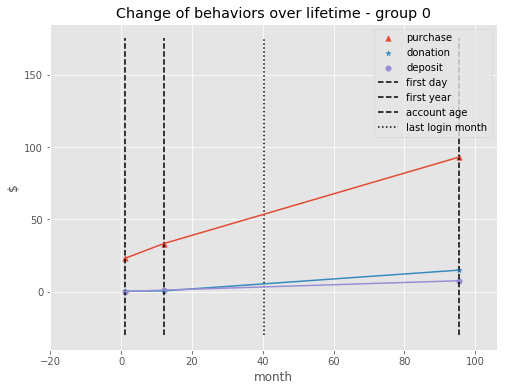

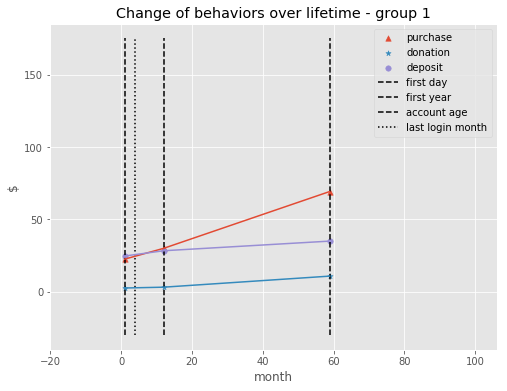

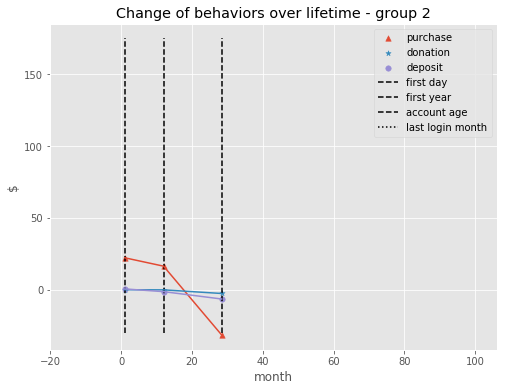

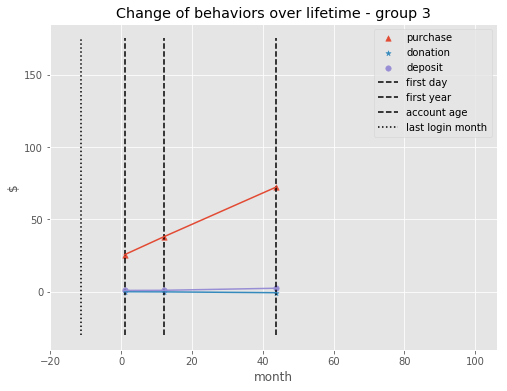

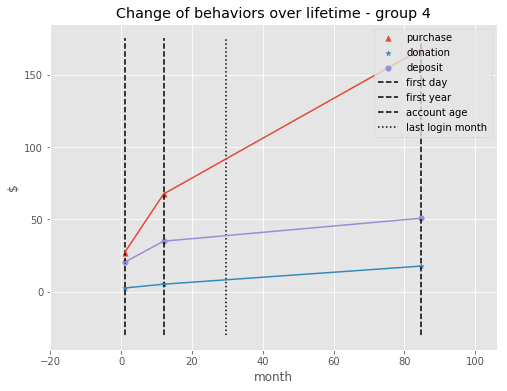

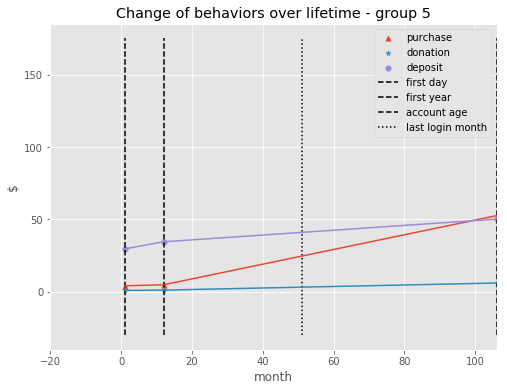

In [168]:
plot_lifespan_trend(center_person,purchase,donations,deposits)



### 4.2 3D Viz - first day to first year

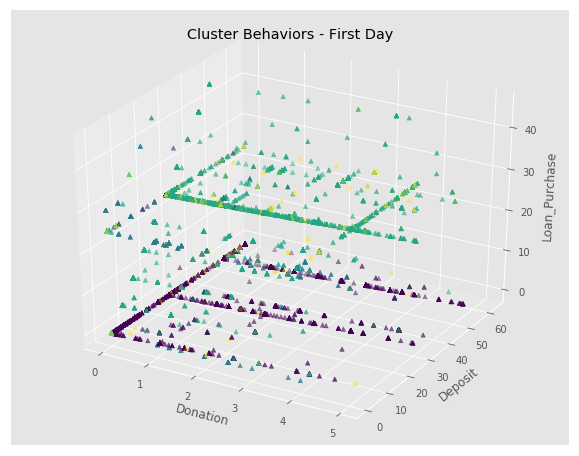

In [28]:
plot_3D_kmeans(ndf_ww[['FIRST_DAY_DONATION_TOTAL',
       'FIRST_DAY_DEPOSIT_TOTAL', 'FIRST_DAY_LOAN_PURCHASE_TOTAL']].values,ndf_ww['clustering_6d'],"Donation","Deposit","Loan_Purchase","Cluster Behaviors - First Day")

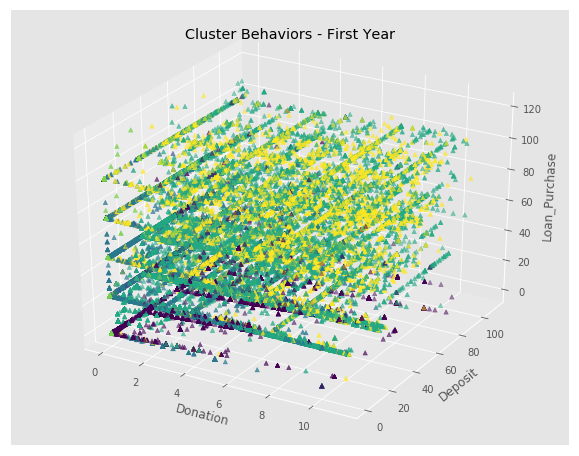

In [27]:
plot_3D_kmeans(ndf_ww[['FIRST_YEAR_DONATION_TOTAL',
       'FIRST_YEAR_DEPOSIT_TOTAL', 'FIRST_YEAR_LOAN_PURCHASE_TOTAL']].values,ndf_ww['clustering_6d'],"Donation","Deposit","Loan_Purchase","Cluster Behaviors - First Year")

###  4.3 radar plot to compare on different aspects

**First Day**

In [155]:
radar3 = center_person[['FIRST_DAY_DONATION_TOTAL',"FIRST_DAY_DEPOSIT_TOTAL",'FIRST_DAY_LOAN_PURCHASE_TOTAL']]

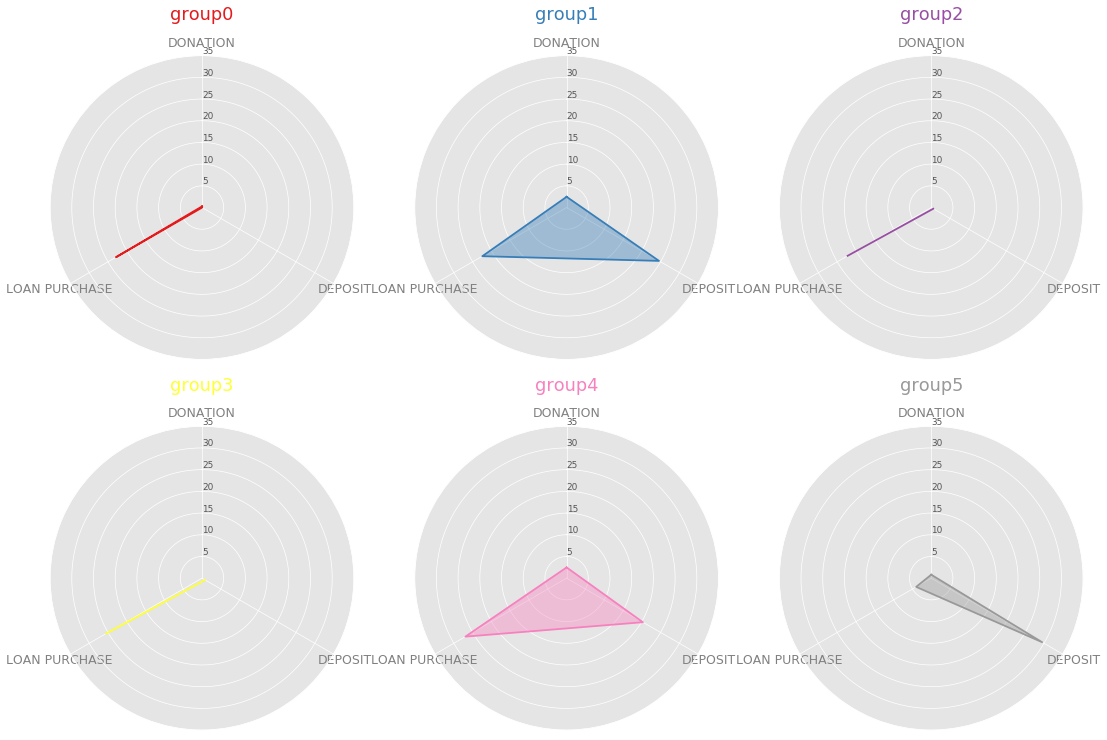

In [169]:
plot_radar(radar3,figname='first_day',dpi=64,num_of_cat=True,ylim=(0,35))

**Life time**

In [73]:
radar1 = center_person[['LIFETIME_DONATION_TOTAL',
       'LIFETIME_DEPOSIT_TOTAL', 'LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL']]

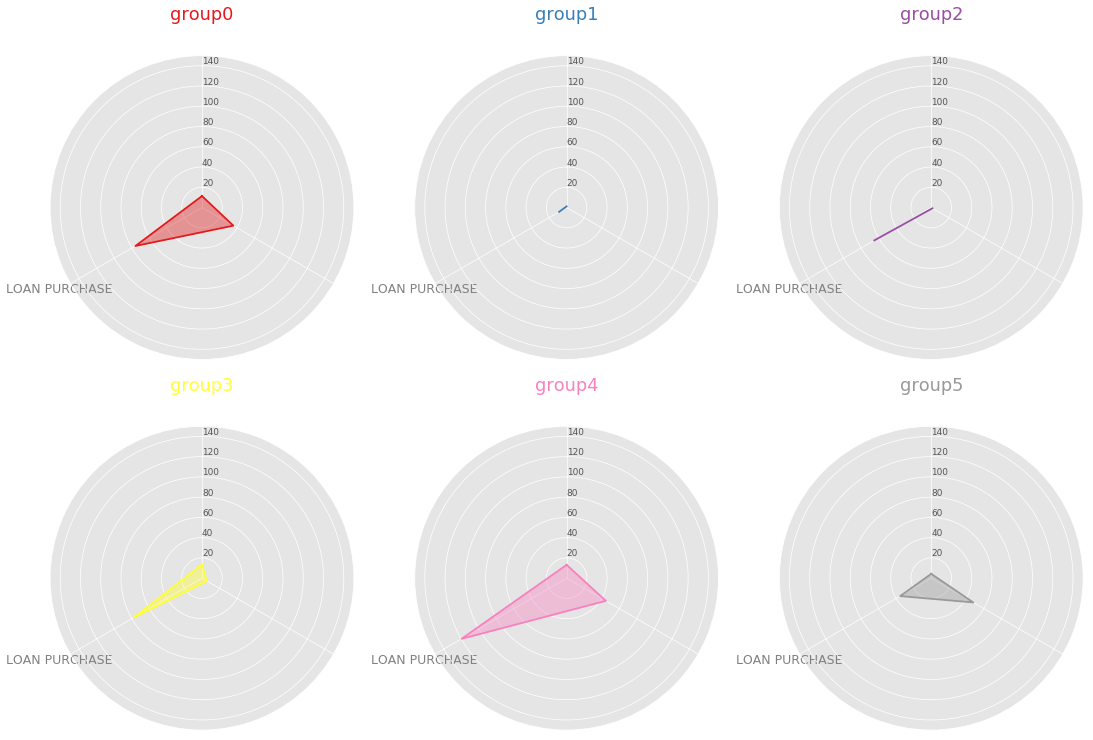

In [77]:
plot_radar(radar1,dpi=64,num_of_cat=True,ylim=(0,150))

**First Year**

In [78]:
radar2 = center_person[['FIRST_YEAR_DONATION_TOTAL',"FIRST_YEAR_DEPOSIT_TOTAL",'FIRST_YEAR_LOAN_PURCHASE_TOTAL']]

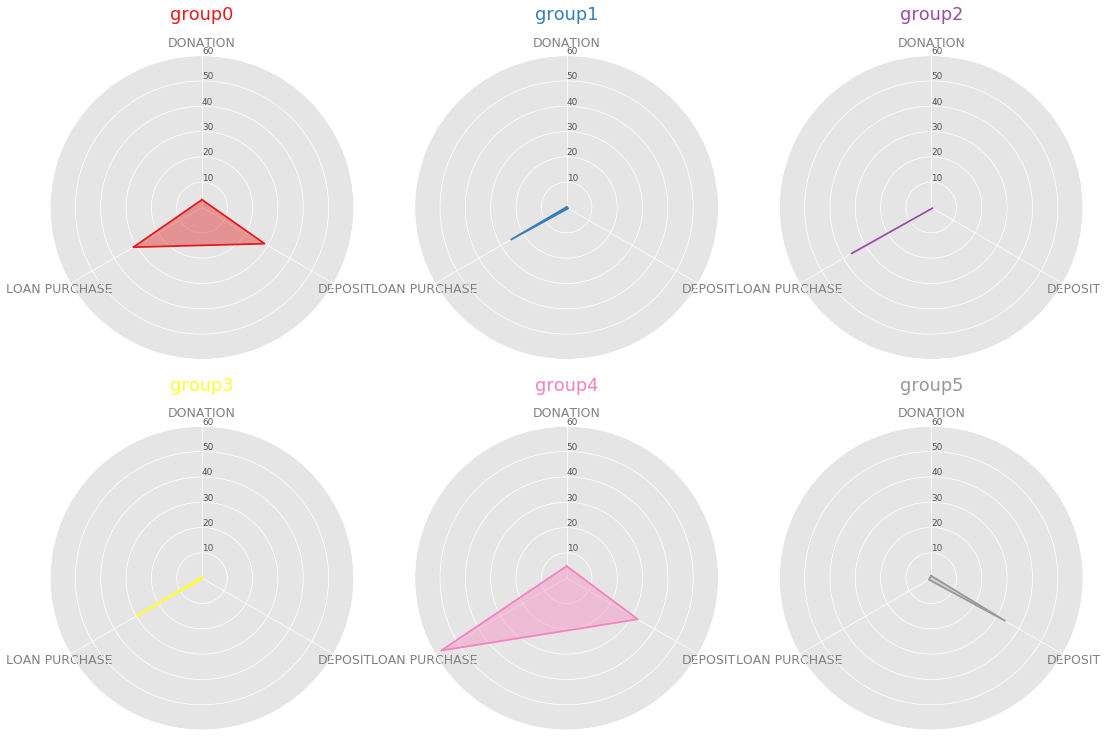

In [81]:
plot_radar(radar2,dpi=64,num_of_cat=True,ylim=(0,60))

**Identity**

In [64]:
radar4 = center_person[['IS_CORPORATE_CAMPAIGN_USER','IS_FREE_TRIAL_USER', 'IS_INACTIVE_CREDIT_DONOR']]

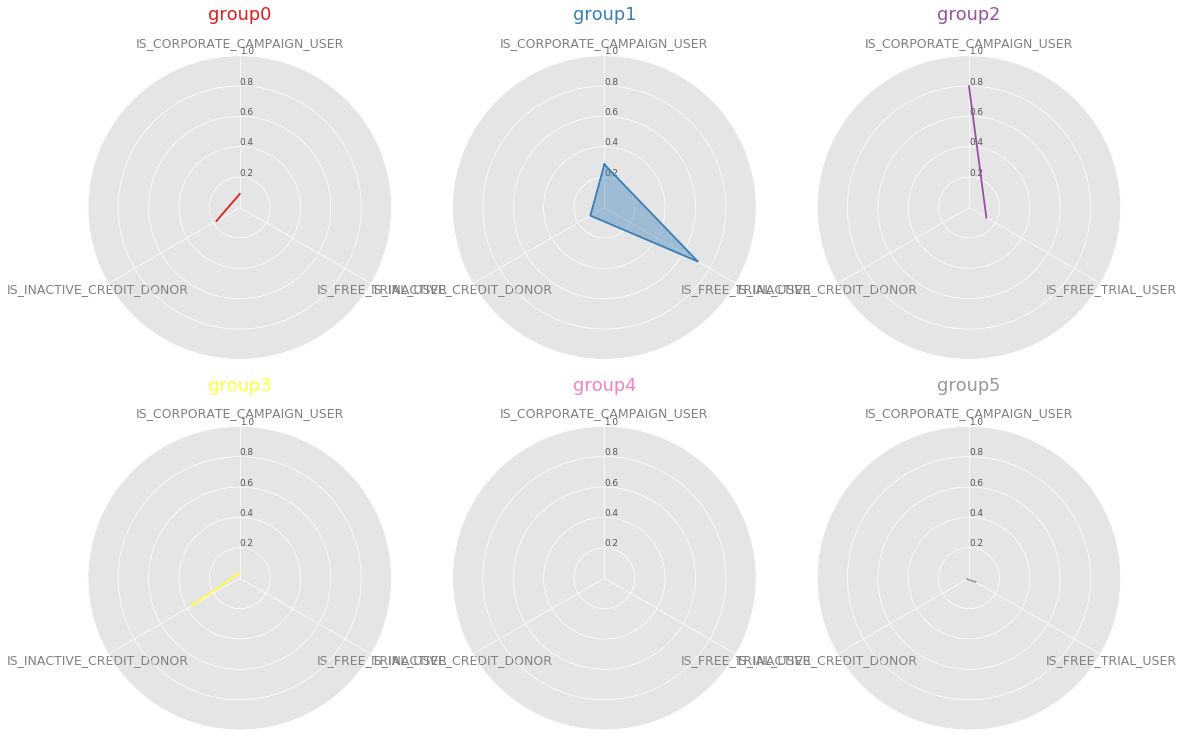

In [65]:
plot_radar(radar4,ylim=(0,1))

**Team activities**

In [67]:
radar5 = center_person[['NUM_TEAM_MEMBERSHIPS',
 'NUM_TEAM_LOANS',
 'NUM_TEAM_MESSAGES']]

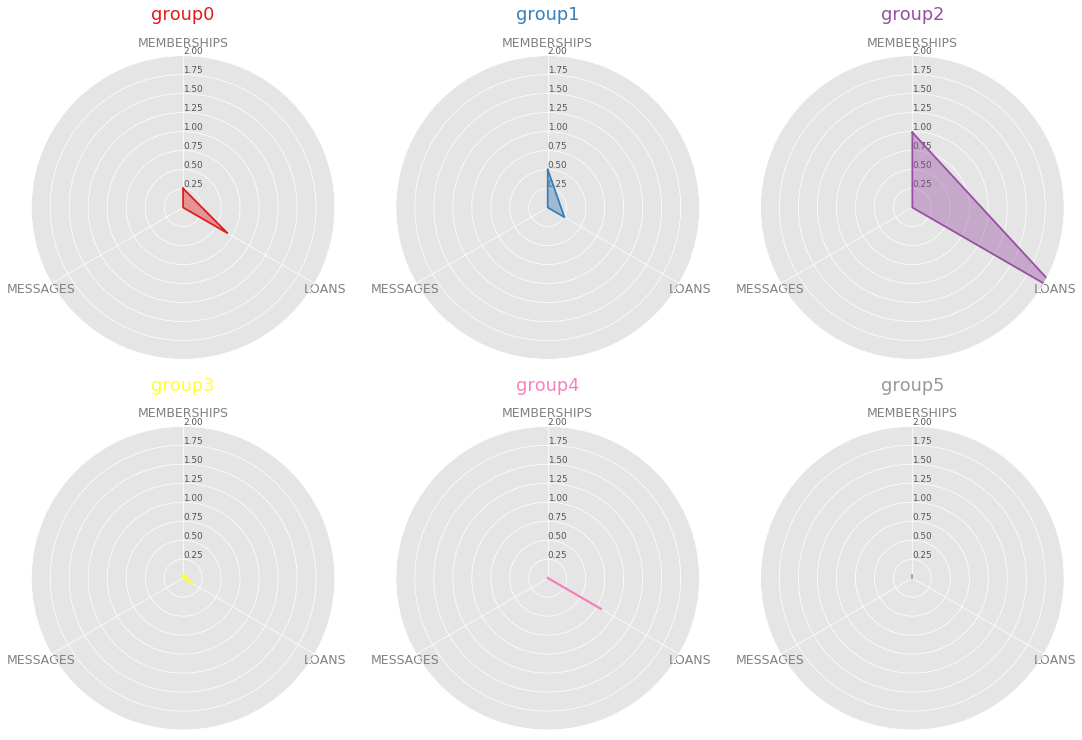

In [68]:
plot_radar(radar5,ylim=(0,2),category=True)

In [71]:
radar7 = center_person[['FIRST_YEAR_DEPOSIT_OCCASION_NUM',
 'FIRST_YEAR_LOAN_PURCHASE_OCCASION_NUM',
 'FIRST_YEAR_DONATION_OCCASION_NUM',
 'FIRST_YEAR_EMAIL_REFERRAL_DONATION_OCCASION_NUM',
 'FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_OCCASION_NUM'
 ]]

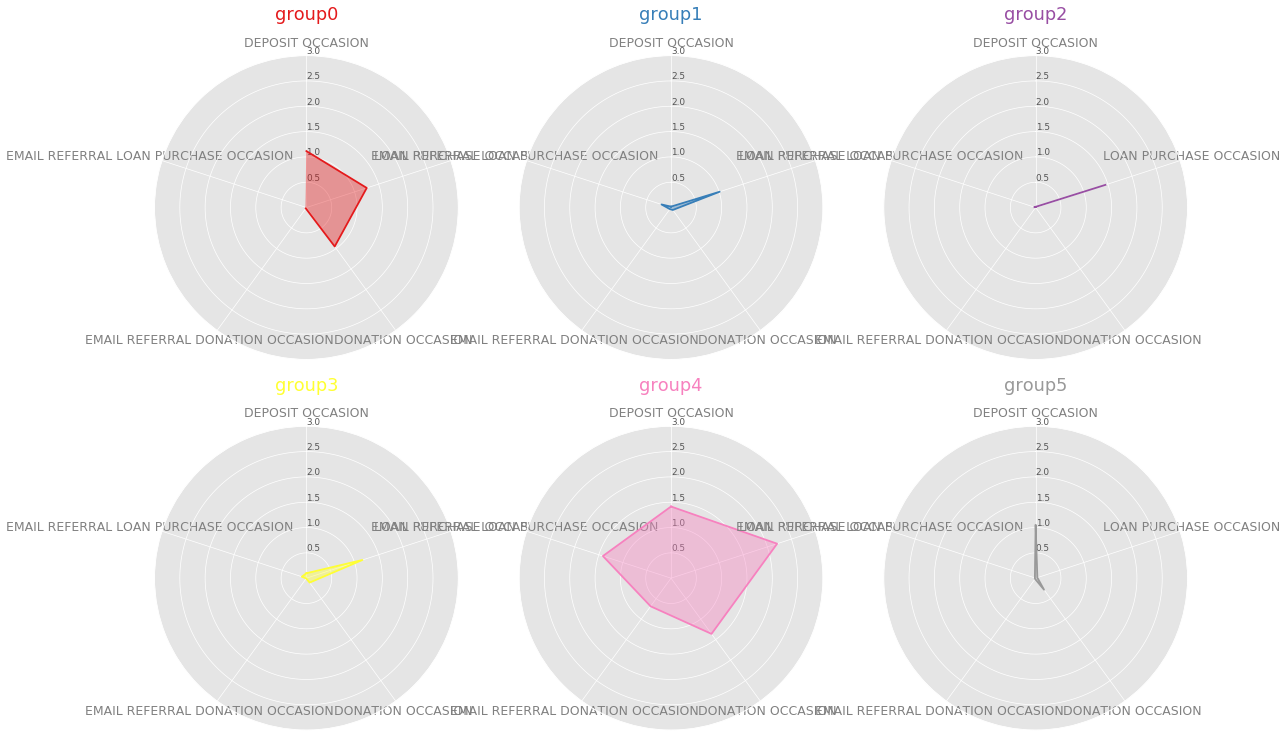

In [82]:
plot_radar(radar7,ylim=(0,3),num_of_cat=True)

In [69]:
radar8 = center_person[list(center_person.filter(regex=("FIRST_TRANSACTION_REFERRAL")))]

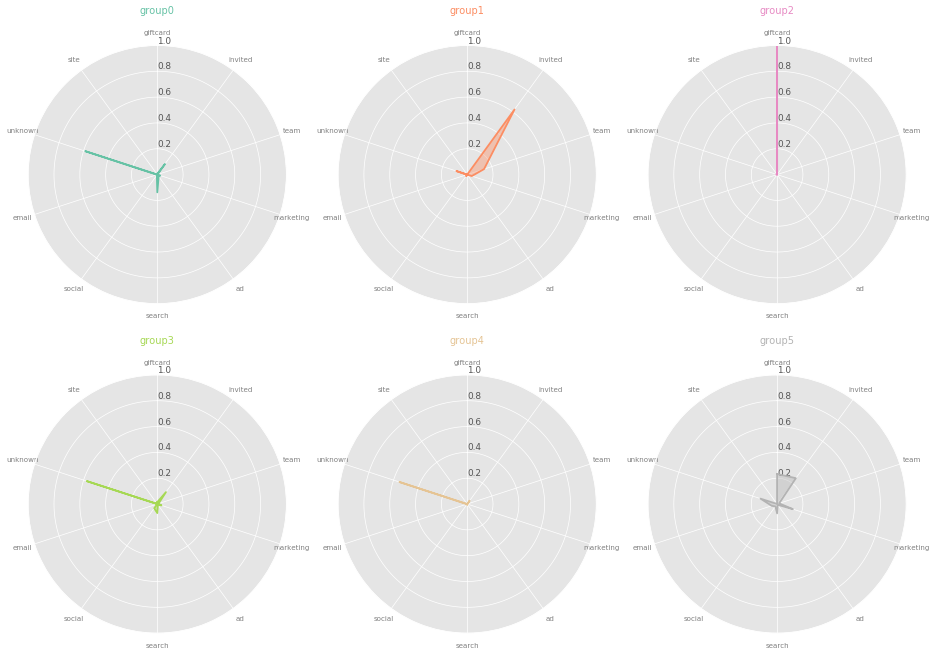

In [70]:
plot_radar(radar8,category=True,ylim=(0,))

## 5. Segments

### 5.1  Account age and Last login month

### One-time lenders

In [90]:
ndf_ww[ndf_ww['clustering_6d'] == 0].shape[0]/ndf_ww.shape[0]

0.30063842021713166

In [96]:
ndf_ww[ndf_ww['clustering_6d'] == 0].columns

Index(['ACCOUNT_AGE_MONTHS', 'IS_CORPORATE_CAMPAIGN_USER',
       'IS_FREE_TRIAL_USER', 'IS_INACTIVE_CREDIT_DONOR',
       'LIFETIME_DONATION_TOTAL', 'LIFETIME_DEPOSIT_TOTAL',
       'LIFETIME_ACCOUNT_LOAN_PURCHASE_TOTAL',
       'LIFETIME_PROXY_LOAN_PURCHASE_TOTAL',
       'LIFETIME_LENDER_WEIGHTED_AVERAGE_LOAN_TERM',
       'FIRST_YEAR_DEPOSIT_TOTAL', 'FIRST_YEAR_LOAN_PURCHASE_TOTAL',
       'FIRST_YEAR_DONATION_TOTAL', 'FIRST_YEAR_EMAIL_REFERRAL_DONATION_TOTAL',
       'FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_TOTAL',
       'FIRST_DAY_DEPOSIT_TOTAL', 'FIRST_DAY_LOAN_PURCHASE_TOTAL',
       'FIRST_DAY_DONATION_TOTAL', 'FIRST_YEAR_DEPOSIT_OCCASION_NUM',
       'FIRST_YEAR_LOAN_PURCHASE_OCCASION_NUM',
       'FIRST_YEAR_DONATION_OCCASION_NUM',
       'FIRST_YEAR_EMAIL_REFERRAL_DONATION_OCCASION_NUM',
       'FIRST_YEAR_EMAIL_REFERRAL_LOAN_PURCHASE_OCCASION_NUM',
       'NUM_TEAM_MEMBERSHIPS', 'NUM_TEAM_LOANS', 'NUM_TEAM_MESSAGES',
       'NUM_LOAN_COMMENTS', 'NUM_JOURNAL_COMMENTS', 'NU

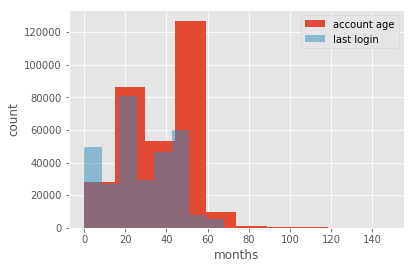

In [103]:
ndf_ww[ndf_ww['clustering_6d'] == 0]['ACCOUNT_AGE_MONTHS'].hist(label='account age')
ndf_ww[ndf_ww['clustering_6d'] == 0]['last_login_today_months'].hist(alpha=0.5,label='last login')

plt.xlabel('months')
plt.ylabel('count')
plt.legend()
plt.savefig('one_time_lenders_login.png')

In [ ]:
ndf_ww[ndf_ww['clustering_6d'] == 0]

### Card Redeemers

In [105]:
ndf_ww[ndf_ww['clustering_6d'] == 1].shape[0]/ndf_ww.shape[0]

0.1985029807687582

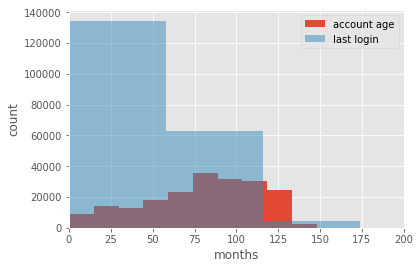

In [110]:
ndf_ww[ndf_ww['clustering_6d'] == 1]['ACCOUNT_AGE_MONTHS'].hist(label='account age')
ndf_ww[ndf_ww['clustering_6d'] == 1]['last_login_today_months'].hist(alpha=0.5,label='last login')

plt.xlabel('months')
plt.ylabel('count')
plt.legend()
plt.xlim(0,200)
plt.savefig('redeemers_login.png')

### Promising supporters

In [106]:
ndf_ww[ndf_ww['clustering_6d'] == 2].shape[0]/ndf_ww.shape[0]

0.2583228076728379

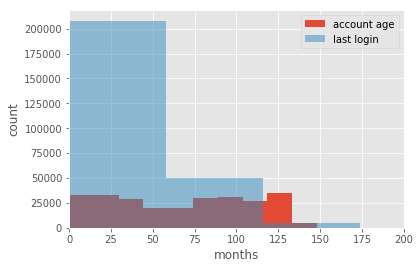

In [111]:
ndf_ww[ndf_ww['clustering_6d'] == 2]['ACCOUNT_AGE_MONTHS'].hist(label='account age')
ndf_ww[ndf_ww['clustering_6d'] == 2]['last_login_today_months'].hist(alpha=0.5,label='last login')

plt.xlabel('months')
plt.ylabel('count')
plt.legend()
plt.xlim(0,200)
plt.savefig('promising_supporters_login.png')

### Long-term depositors

In [112]:
ndf_ww[ndf_ww['clustering_6d'] == 3].shape[0]/ndf_ww.shape[0]


0.07171832841043686

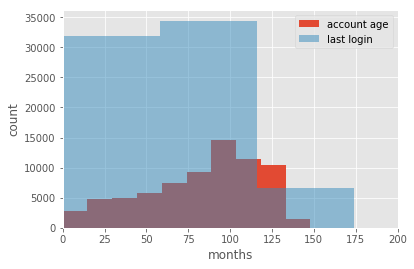

In [114]:
ndf_ww[ndf_ww['clustering_6d'] == 3]['ACCOUNT_AGE_MONTHS'].hist(label='account age')
ndf_ww[ndf_ww['clustering_6d'] == 3]['last_login_today_months'].hist(alpha=0.5,label='last login')

plt.xlabel('months')
plt.ylabel('count')
plt.legend()
plt.xlim(0,200)
plt.savefig('depositors_login.png')

### Unengaged Newbies

In [115]:
ndf_ww[ndf_ww['clustering_6d'] == 4].shape[0]/ndf_ww.shape[0]


0.14616726707982955

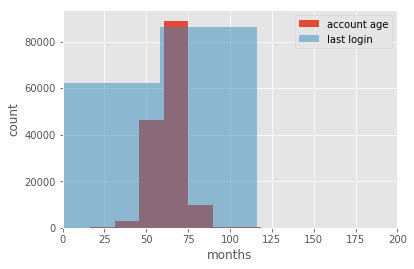

In [117]:
ndf_ww[ndf_ww['clustering_6d'] == 4]['ACCOUNT_AGE_MONTHS'].hist(label='account age')
ndf_ww[ndf_ww['clustering_6d'] == 4]['last_login_today_months'].hist(alpha=0.5,label='last login')

plt.xlabel('months')
plt.ylabel('count')
plt.legend()
plt.xlim(0,200)
plt.savefig('newbies_login.png')